In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
sys.path.append("..")

from utils import *
from errors import *

from sklearn.decomposition import PCA
from skimage.color import rgb2gray

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches


In [3]:
# Loaded a set of images
root_dir = "../../data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images from images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images from groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n = 19 # Only use 10 images for training

Loading 20 images from images
Loading 20 images from groundtruth


### --- TESTING ON GRAY IMAGES ---

(19, 400, 400)


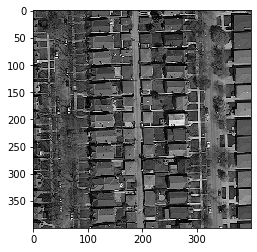

In [4]:
imgs_gray = [rgb2gray(imgs[i]) for i in range(n)]

print(np.shape(imgs_gray))
plt.imshow(imgs_gray[0], cmap='Greys_r')

### Linearize image

In [5]:
nb_image, nb_x, nb_y = np.shape(imgs_gray);
imgs_gray_lin = np.zeros((nb_image, nb_x*nb_y))
for k in range(nb_image):
    imgs_gray_lin[k] = np.asarray([imgs_gray[k][i][j] for i in range(nb_x) for j in range(nb_y)])

print(np.shape(imgs_gray_lin))



(19, 160000)


### PCA decomposition

In [6]:
DISPLAY_IMAGES = False
NUMBER_OF_COMPONENTS = 19

In [7]:
pca = PCA(n_components = NUMBER_OF_COMPONENTS)
pca.fit(imgs_gray_lin)
imgs_gray_pca = pca.fit_transform(imgs_gray_lin)
print('Before PCA decomposition: ' + str(np.shape(imgs_gray_lin)))
print('After PCA decomposition: ' + str(np.shape(imgs_gray_pca)))
imgs_gray_restored = pca.inverse_transform(imgs_gray_pca)
imgs_gray_restored = imgs_gray_restored.reshape((nb_image, nb_x, nb_y))
if DISPLAY_IMAGES:
    for i in range(np.shape(imgs_gray)[0]):
        cimg = np.concatenate((imgs_gray[i], imgs_gray_restored[i]), axis=1)
        #cimg = concatenate_images(imgs_gray[i], imgs_gray_restored[i])
        plt.imshow(cimg, cmap='Greys_r')
        plt.xlabel('Image ' + str(i) + ': Original vs Reconstruct with ' + str(NUMBER_OF_COMPONENTS) + ' components')
        plt.show()

Before PCA decomposition: (19, 160000)
After PCA decomposition: (19, 19)


### Display some statistics of PCA decompostion

In [8]:
reduction = (1 - float(np.size(imgs_gray_pca)) / np.size(imgs_gray)) * 100
print('Reduction in the number of component of ' + str(reduction) + ' %')
average_mse = 0 
for i in range(np.shape(imgs_gray)[0]):
    average_mse += mse(imgs_gray[i], imgs_gray_restored[i])
print('Cummulative mean square error of the PCA: ' + str(average_mse))
average_mse /= np.shape(imgs_gray)[0]
print('Average mean square error of the PCA: ' + str(average_mse))


Reduction in the number of component of 99.98812500000001 %
Cummulative mean square error of the PCA: 7.284189783049615e-29
Average mean square error of the PCA: 3.833784096341903e-30


### --- TESTING ON COLOR IMAGES ---

### Linearize image

In [9]:
nb_image, nb_x, nb_y, nb_channels = np.shape(imgs);
nb_image = n
imgs_lin = np.zeros((nb_image, nb_x*nb_y*nb_channels))
for k in range(nb_image):
    imgs_lin[k] = np.asarray([imgs[k][i][j][c] for i in range(nb_x) for j in range(nb_y) for c in range(nb_channels)])

print(np.shape(imgs_lin))


(19, 480000)


### Verification of the linearization process

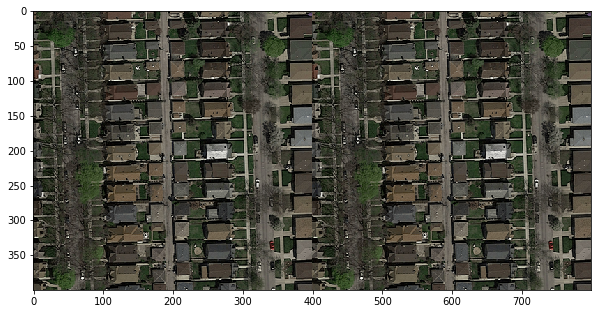

In [10]:
cimg = concatenate_images(imgs[0], imgs_lin.reshape((nb_image, nb_x, nb_y, nb_channels))[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

### PCA decomposition

In [11]:
DISPLAY_IMAGES = False
NUMBER_OF_COMPONENTS = 19

In [12]:
pca = PCA(n_components = NUMBER_OF_COMPONENTS)
pca.fit(imgs_lin)
imgs_pca = pca.fit_transform(imgs_lin)
print('Before PCA decomposition: ' + str(np.shape(imgs_lin)))
print('After PCA decomposition: ' + str(np.shape(imgs_pca)))
imgs_restored = pca.inverse_transform(imgs_pca)
imgs_restored = imgs_restored.reshape((nb_image, nb_x, nb_y, nb_channels))
#Normalization of the restored image
imgs_restored = np.where(imgs_restored<0, 0, imgs_restored)
imgs_restored = np.where(imgs_restored>1, 1, imgs_restored)
if DISPLAY_IMAGES:
    for i in range(np.shape(imgs)[0]):
        cimg = np.concatenate((imgs[i], imgs_restored[i]), axis=1)
        plt.imshow(cimg)
        plt.xlabel('Image ' + str(i) + ': Original vs Reconstruct with ' + str(NUMBER_OF_COMPONENTS) + ' components')
        plt.show()

Before PCA decomposition: (19, 480000)
After PCA decomposition: (19, 19)


### Display some statistics of PCA decompostion

In [13]:
reduction = (1 - float(np.size(imgs_pca)) / np.size(imgs)) * 100
print('Reduction in the number of component of ' + str(reduction) + ' %')
average_mse = 0 
for i in range(nb_image):
    average_mse += mse(imgs[i], imgs_restored[i])
print('Cummulative mean square error of the PCA: ' + str(average_mse))
average_mse /= nb_image
print('Average mean square error of the PCA: ' + str(average_mse))



Reduction in the number of component of 99.99623958333333 %
Cummulative mean square error of the PCA: 2.179568841352825e-28
Average mean square error of the PCA: 1.1471414954488554e-29


### Verification of reconstruction on another image -- TODO

In [ ]:
imgs_lin_20 = np.zeros((1, nb_x*nb_y*nb_channels))
imgs_lin_20[0] = np.asarray([imgs[19][i][j][c] for i in range(nb_x) for j in range(nb_y) for c in range(nb_channels)])
print(np.shape(imgs_lin_20))

In [ ]:
imgs_pca_20 = pca.fit_transform(imgs_lin_20)
imgs_restored_20 = pca.inverse_transform(imgs_pca_20)
imgs_restored_20 = imgs_restored_20.reshape((nb_x, nb_y, nb_channels))
imgs_restored_20 = np.where(imgs_restored_20<0, 0, imgs_restored_20)
imgs_restored_20 = np.where(imgs_restored_20>1, 1, imgs_restored_20)

cimg = np.concatenate((imgs[19], imgs_restored_20), axis=1)
plt.imshow(cimg)
plt.show()